In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Read Data

In [4]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
data_path = 'Data/'

# Full datasets

In [5]:
# Amazon
df_am = pd.read_pickle(path + data_path + 'Amazon/Amazon_full')
# subsets
# names_am = ['Amazon_05_users', 'Amazon_01_users', 'Amazon_005_users', 'Amazon_001_users']

# MovieLens
# df_ml = pd.read_pickle(path + data_path + 'ML/ML_full')
# subsets
# names_ml = ['ML_05_users', 'ML_01_users', 'ML_005_users', 'ML_001_users']

In [6]:
df_am

,user,item,datetime,rating
40273,A2X8QS4ZWXW7QP,B0000ZCE0O,2003-05-26,5.0
32383,ACJQVWGHRRLHJ,B0000TIKK8,2004-01-12,5.0
393270,A4SMAB99DG0AT,B000GAWSEU,2004-11-11,4.0
46906,A2PUJ083AYU5Y1,B0001KOBJ0,2004-12-20,3.0
46905,A31RMV81JXPB2E,B0001KOBJ0,2005-01-05,2.0
...,...,...,...,...
11283948,AQOLEE4P1VQF,B01HHAY2IG,2018-10-04,5.0
11285369,A3SV0PTMJ54B0Z,B01HJC17Y4,2018-10-04,5.0
11284671,A3SV0PTMJ54B0Z,B01HI6GWI2,2018-10-04,5.0
11284373,AD0LHOGZVSY4J,B01HHNB9LQ,2018-10-04,3.0


## MovieLens 25M

In [5]:
df_ml_25m = pd.read_pickle(path + '/Data/ML/ml_1m')

In [3]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [4]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [6]:
%%time
df = getDF('Data/Clothing_Shoes_and_Jewelry_5.json.gz')

Wall time: 2h 24min 28s


# Read Datasets

## Amazon

In [5]:
%%time
df = pd.read_pickle('Data/Amazon_CSJ')

Wall time: 1min 10s


In [85]:
%%time
df_40k = pd.read_pickle(path + 'Data/Amazon/am_40k_users')

Wall time: 165 ms


## Get Stats

In [6]:
def get_time_diff(x):
    x = pd.Series(x)
    res = x.max() - x.min()
    if res == pd.Timedelta(0):
        res += pd.Timedelta(1, unit='d')
    return res

In [111]:
def get_stats(df):
    features = list(df)
    
    if 'user_id' not in features:
        df['user_id'] = df.reviewerID.astype('category').cat.codes
    if 'item_id' not in features:
        df['item_id'] = df.asin.astype('category').cat.codes
    if 'unixReviewTime' in features:
        df['datetime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
    if 'overall' in features:
        df = df.rename(columns={'overall':'rating'})
    
    user_group = df.groupby('user_id')
    item_group = df.groupby('item_id')
    stats = {}
    
    stats['avg ratings per user'] = user_group['rating'].count().mean()
    stats['avg ratings per item'] = item_group['rating'].count().mean()
    
    stats['Median Ratings Per User'] = user_group['rating'].count().median()
    stats['Median Ratings per item'] = item_group['rating'].count().median()
    
    datetime_lists = user_group['datetime'].apply(list)
    time_in_sys = datetime_lists.apply(get_time_diff)
   
    datetime_lists_i = item_group['datetime'].apply(list)
    time_in_sys_i = datetime_lists_i.apply(get_time_diff)
    
    stats['avg time user in system'] = time_in_sys.mean()
    stats['avg time item in system'] = time_in_sys_i.mean()
    
    stats['average rating'] = df['rating'].mean()
    stats['total users'] = df.user_id.unique().size
    stats['total items'] = df.item_id.unique().size
    stats['sparseness'] = 1 - len(df) / (len(df['user_id'].unique()) * len(df['item_id'].unique()))
    stats['total ratings'] = len(df)
    
#     print('rows ', len(df), 
#           '\n#ratings/user', round(norpu,2), 
#           '\n#ratings/item', round(norpi,2), 
#           '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
#           '\n#users ', df['user_id'].unique().size, 
#           '\n#items ', df['item_id'].unique().size, 
#           '\nsparse ', round(sparseness,5))

    return stats

## Stats Amazon Full

In [58]:
%%time
stats = get_stats(df)

Wall time: 16min 42s


In [59]:
stats

{'avg ratings per user': 9.252822466257488,
 'avg ratings per item': 29.946197241401272,
 'Median Ratings Per User': 7.0,
 'Median Ratings per item': 10.0,
 'avg time user in system': Timedelta('806 days 23:04:01.269581'),
 'avg time item in system': Timedelta('931 days 01:58:06.552494'),
 'total users': 1219678,
 'total items': 376858,
 'sparseness': 0.9999754474564259,
 'total ratings': 11285464}

## Stats Amazon 40k Users

In [114]:
%%time
stats_40k = get_stats(df_40k)

Wall time: 1min 39s


In [115]:
stats_40k = pd.DataFrame().from_dict(stats_40k, orient='index')

In [117]:
stats_40k.to_csv(path + 'Data/EDA/40k_am_stats.csv')

In [89]:
df_40k.user_id.unique()

array([34371,  7176, 11529, ..., 22889, 12463,  1460])

# 40K users subset for all runs

In [41]:
get_stats(df_am)

rows  10592657 
#ratings/user 8.73 
#ratings/item 28.22 
average rating 4.28 
#users  1213729 
#items  375397 
sparse  0.99998


In [30]:
get_stats(subset)

rows  700146 
#ratings/user 8.75 
#ratings/item 3.43 
average rating 4.28 
#users  80000 
#items  204272 
sparse  0.99996


In [25]:
get_stats(df_ml)

rows  25000095 
#ratings/user 153.81 
#ratings/item 423.39 
average rating 3.53 
#users  162541 
#items  59047 
sparse  0.9974


In [12]:
get_stats(df_ml_1m)

rows  1000209 
#ratings/user 165.6 
#ratings/item 269.89 
average rating 3.58 
#users  6040 
#items  3706 
sparse  0.95532


# Time Sorting Per User

In [ ]:
def time_sort_user(names, data_path):
    for name in names:
        from progressbar import ProgressBar
        pbar = ProgressBar()
        df = pd.read_pickle(data_path + name)
        users = df.user.unique()
        new_df = pd.DataFrame(columns=list(df))
        for u in pbar(users):
            df_u = df[df['user']==u]
            df_u = df_u.sort_values(by='datetime')
            new_df = pd.concat([new_df, df_u])
        new_df.to_pickle(data_path + name)    

In [ ]:
path + data_path + 'Amazon/' + names_am[0]

In [ ]:
# Amazon
file_path = path + data_path + 'Amazon/'
time_sort_user([names_am[0]], file_path)

In [ ]:
names_ml[:3]

In [ ]:
# MovieLens
file_path = path + data_path + 'ML/'
time_sort_user(names_ml[:3], file_path)

# Exploration

In [129]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
from matplotlib.ticker import MaxNLocator

def eda_plots(df, title, size=(20,16), store_path='', **kwargs):
    
    user_counts = df.groupby('user_id')['item_id'].count()
    item_counts = df.groupby('item_id')['user_id'].count().sort_values(ascending=True)
    norpu = user_counts.mean()
    norpi = item_counts.mean()
#     total_users = df.user_id.unique().size
#     total_items = df.item_id.unique().size
#     sparseness = 1 - len(df) / (len(df['user_id'].unique()) * len(df['item_id'].unique()))
    
#     print('rows ', len(df), 
#           '\n#ratings/user', round(norpu,2), 
#           '\n#ratings/item', round(norpi,2), 
#           '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
#           '\n#users ', df['user_id'].unique().size, 
#           '\n#items ', df['item_id'].unique().size, 
#           '\nsparse ', round(sparseness,5))
    
    fig = plt.figure(figsize=size)
#     fig.suptitle(title, x=0.5, y=0.95, fontsize=22)
    gs = fig.add_gridspec(2,2, wspace=0.4, hspace=0.4)
    
    f_ax1 = fig.add_subplot(gs[0,0])
    plt.hist(df.rating, bins=5)
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.xticks(range(1,6))
    plt.ylabel('Count')
    
    f_ax2 = fig.add_subplot(gs[0,1])
    plt.hist(df.datetime, bins = 20)
    plt.xlabel('Time of Rating (years)')
    plt.ylabel('Count')
    plt.title('Time Distribution of Ratings')

    f_ax3 = fig.add_subplot(gs[1,0])
    plt.hist(item_counts, bins = kwargs['item_bins'])
    plt.xlim(kwargs['item_xlim'])
    plt.title('Number of Ratings per Item')
    plt.xlabel('Reviews per Item')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)
#     plt.xticks(range(0,bound_steps[0],bound_steps[1]))
    
    f_ax4 = fig.add_subplot(gs[1,1])
    plt.hist(user_counts, bins = kwargs['user_bins'])
    plt.xlim(kwargs['user_xlim'])
    plt.title('Number of Reviews per User')
    plt.xlabel('Reviews per User')
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.gca().xaxis.get_majorticklabels()[0].set_x(-0.05)
#     plt.xticks(range(0,bound_steps[0],bound_steps[1]))

    if len(store_path) > 0:
        fig.savefig(store_path, bbox_inches='tight')
        
    plt.show()

In [132]:
plt.rcParams.update({'font.size':30})

## EDA Amazon Full

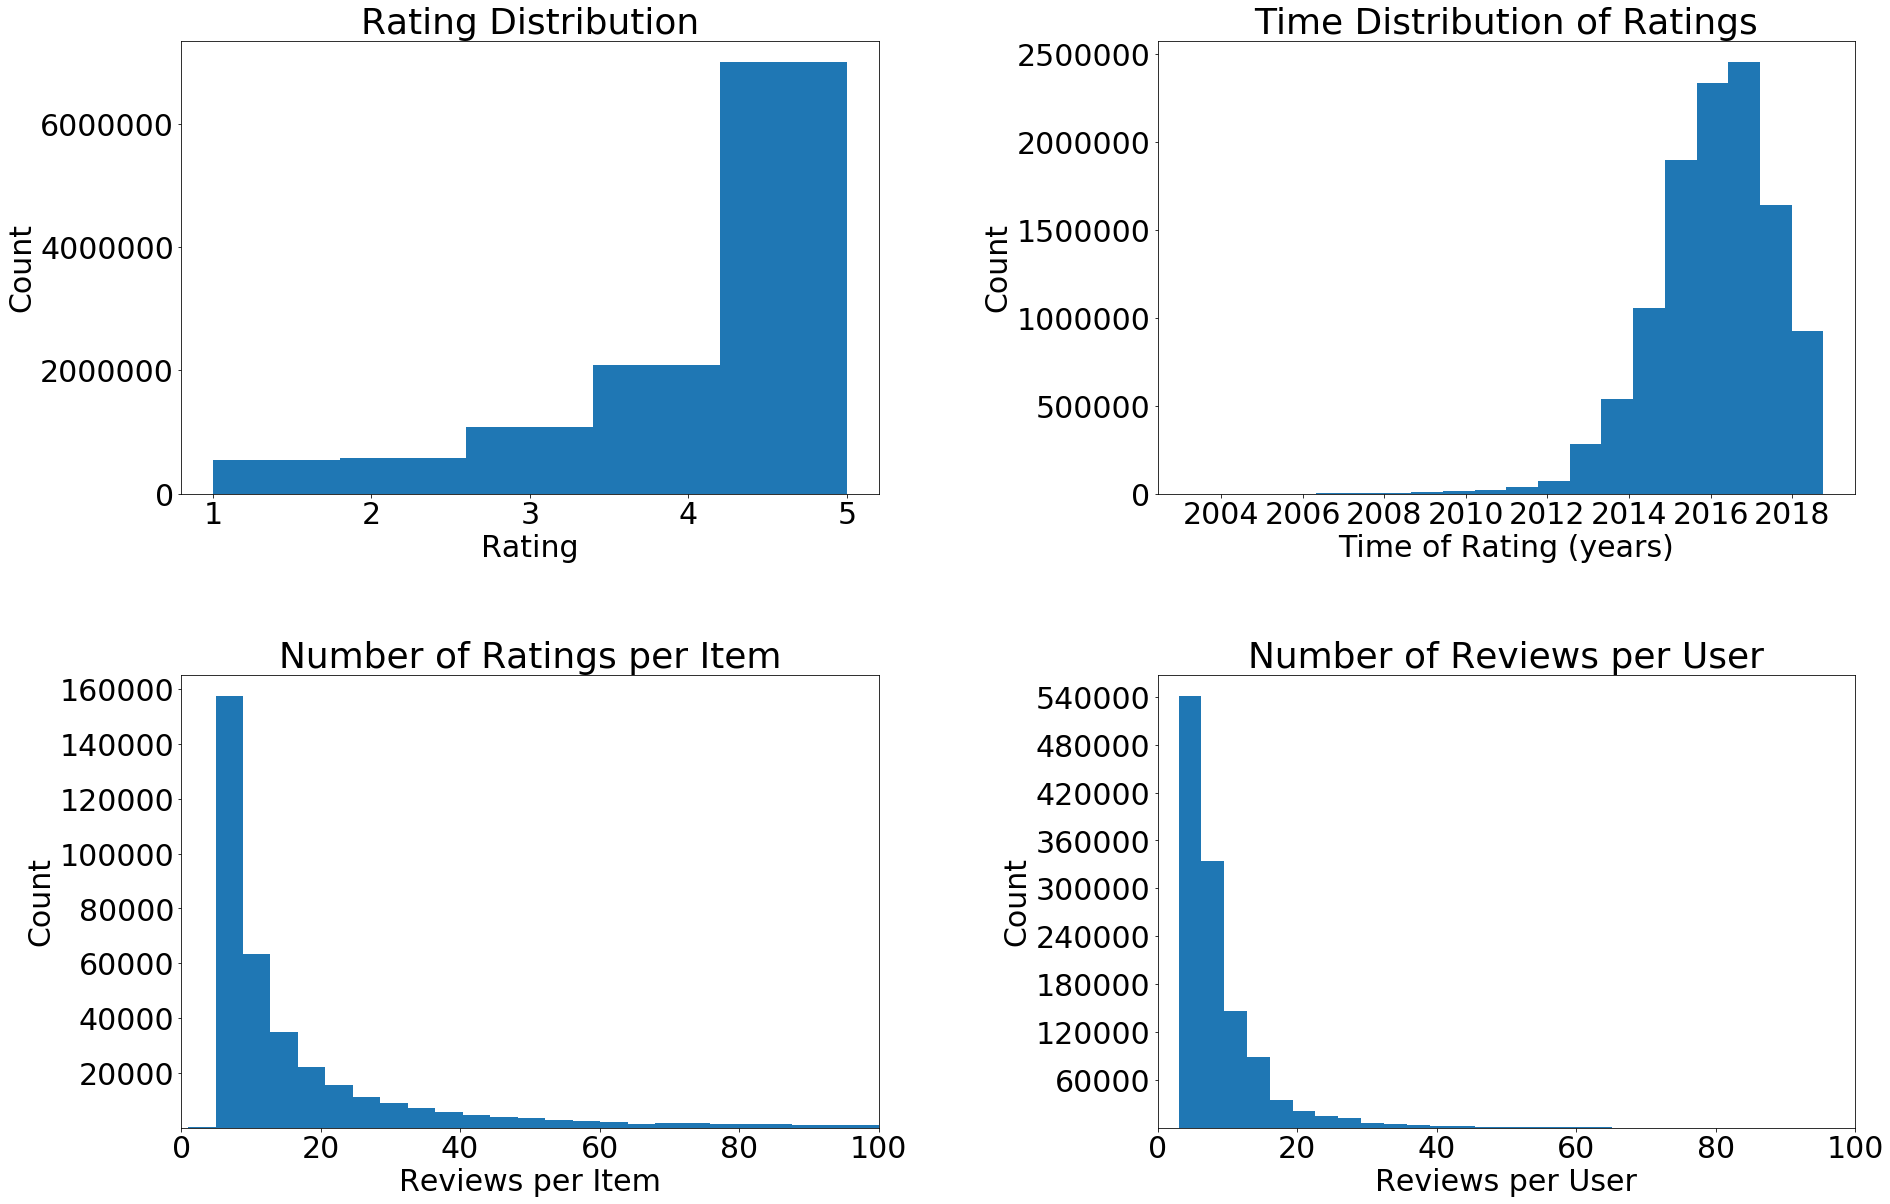

In [133]:
settings = {'item_bins':5000, 'user_bins':150, 'item_xlim':[0,100], 'user_xlim':[0,100]}
eda_plots(df, 'Amazon Shoes Clothing and Jewellery', size=(30,20), store_path=path+'Plots/EDA/EDA_am_full', **settings)

## EDA Amazon 40k Users

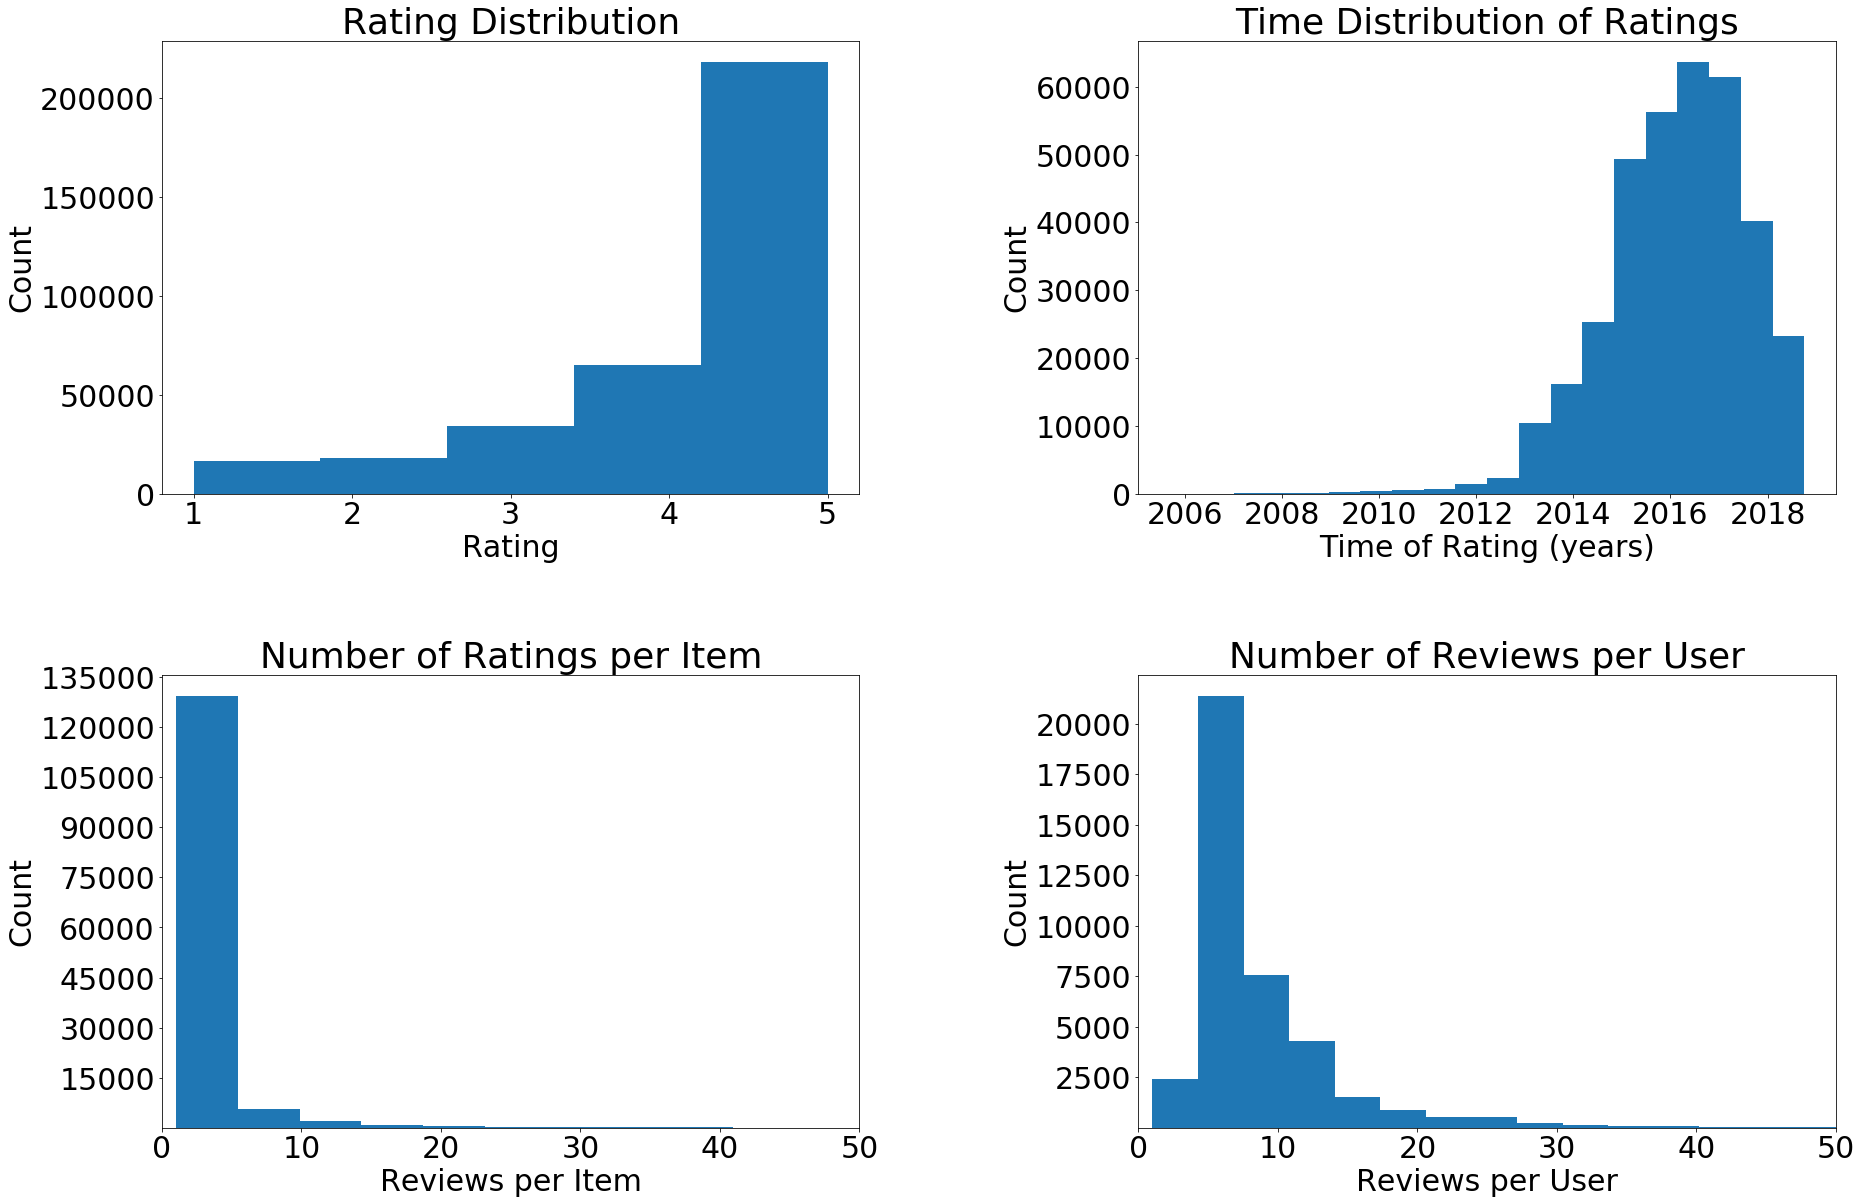

In [134]:
settings = {'item_bins':150, 'user_bins':150, 'item_xlim':[0,50], 'user_xlim':[0,50]}
eda_plots(df_40k, 'Amazon 40k Users', size=(30,20), store_path=path+'Plots/EDA/EDA_am_40k_users', **settings)

rows  1000209 
#ratings/user 165.6 
#ratings/item 269.89 
average rating 3.58 
#users  6040 
#items  3706 
sparse  0.95532


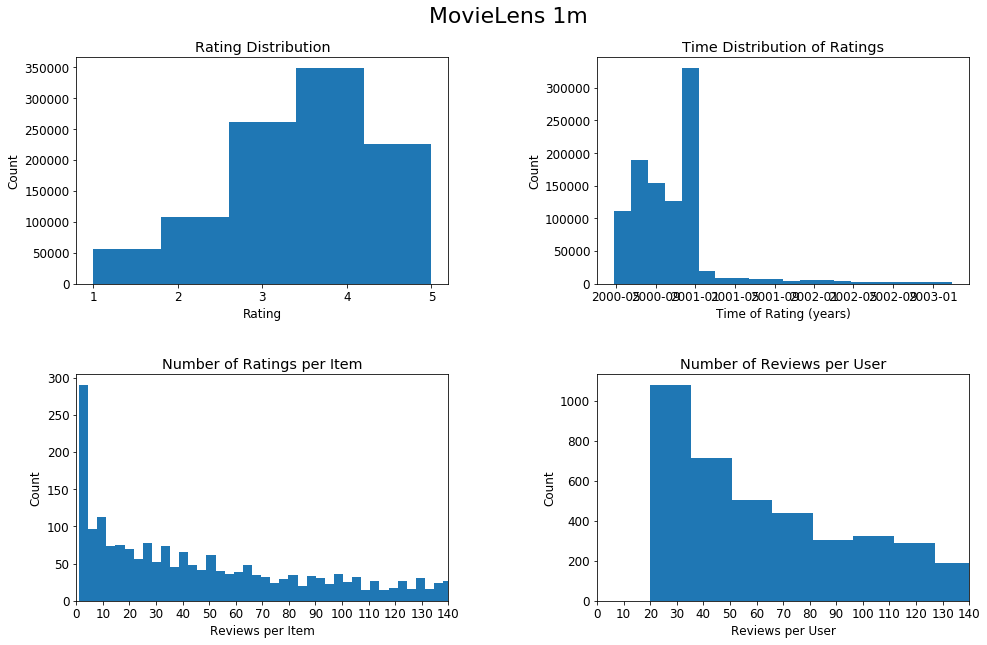

In [104]:
eda_plots(df_ml_1m, 'MovieLens 1m', size=(16,10), bound_steps=[150,10])

rows  1058788 
#ratings/user 8.72 
#ratings/item 4.28 
average rating 4.28 
#users  121372 
#items  247465 
sparse  0.99996


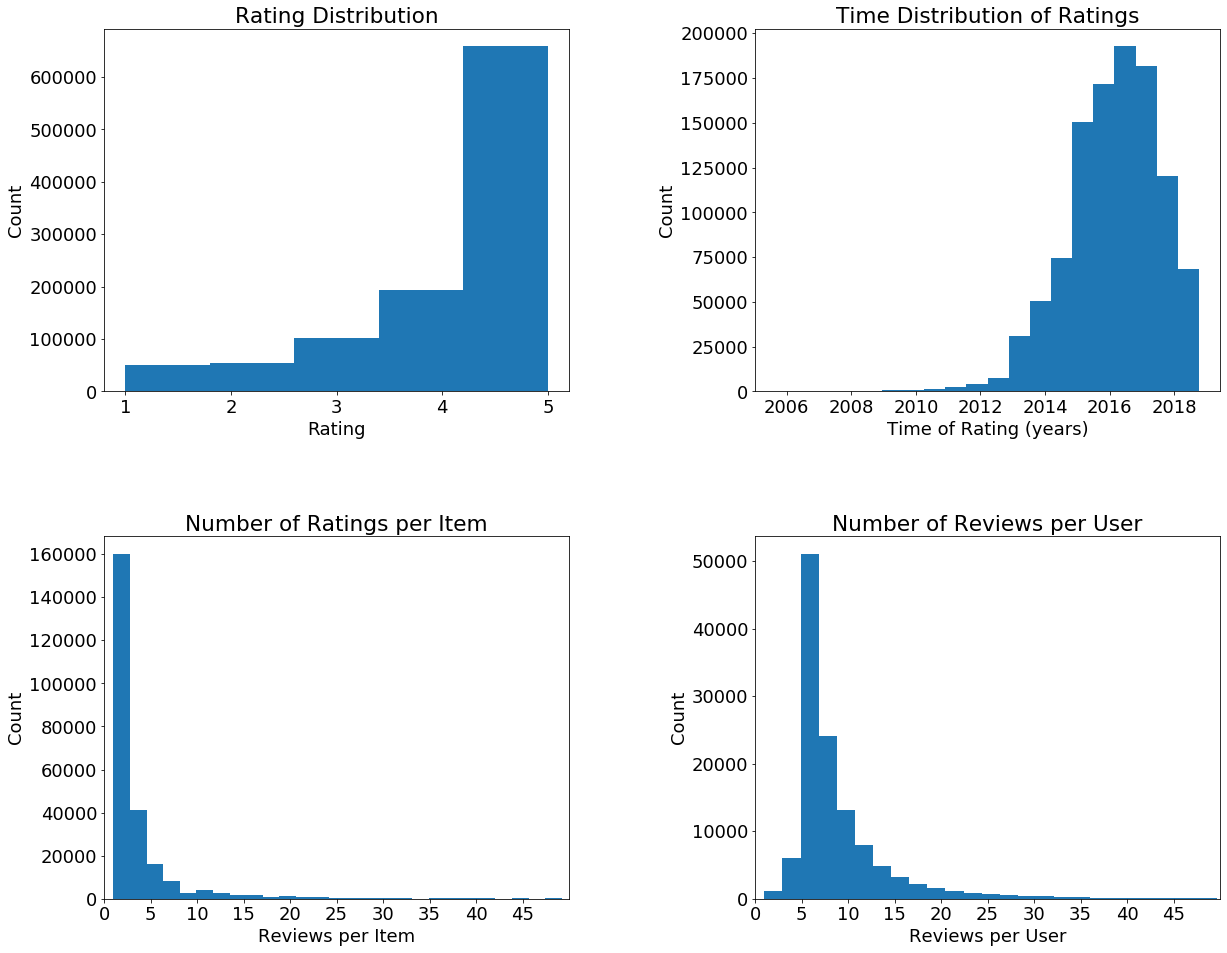

In [370]:
store_name = 'EDA_am_01'
store_path = path + 'Plots/EDA/' + store_name
title = 'Exploratory Data Analysis Amazon 10% of Users'
eda_plots(am, title, store_path=store_path)

In [286]:
ml.groupby('item_id')['rating'].count().sort_values(ascending=False)[:20]

item_id
314     8272
351     8198
292     7968
585     7428
2480    7312
257     6884
475     6434
522     6120
108     5881
2867    5870
581     5752
1166    5746
0       5709
4887    5627
49      5535
1168    5472
1179    5456
2766    5440
840     5261
5840    5191
Name: rating, dtype: int64

In [66]:
am['item_id'] = am.item.astype('category').cat.codes
am['user_id'] = am.user.astype('category').cat.codes

In [68]:
item_counts_ml = ml.groupby('item_id')['user_id'].count().sort_values(ascending=False)
item_counts_am = am.groupby('item_id')['user_id'].count().sort_values(ascending=False)

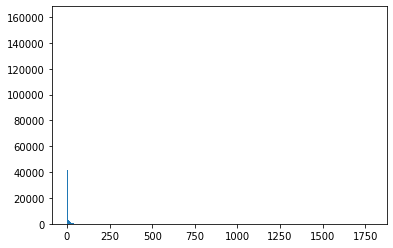

In [211]:
plt.hist(item_counts_am, bins=1000)
plt.show()

In [32]:
from brokenaxes import brokenaxes

In [74]:
len(item_counts_am)

247465

In [202]:
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

In [ ]:
x = item_counts_ml.index
y = item_counts_ml
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x,y, s=10)
plt.show()

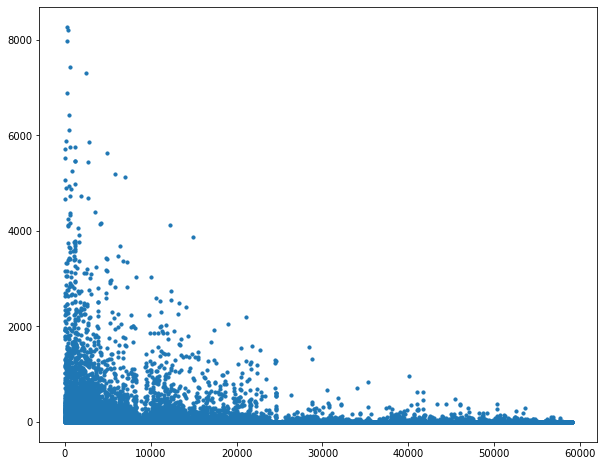

In [207]:
x = item_counts_ml.index
y = item_counts_ml
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x,y, s=10)
plt.show()

# Create Am similar to ML

In [15]:
ml_1m = pd.read_pickle(path + 'Data/ML/ml_1m')

In [18]:
df_am['item_id'] = df_am.item.astype('category').cat.codes
df_am['user_id'] = df_am.user.astype('category').cat.codes

In [21]:
longest_users = pd.DataFrame(df_am.groupby('user_id')['item_id'].count().sort_values(ascending=False)[:ml_1m.user_id.nunique()].index).set_index('user_id')

In [22]:
longest_users

""
user_id
1084346
927864
1023441
171500
324406
...
559411
148696
75458


In [23]:
df_am.set_index('user_id', inplace=True)
am_like_ml = longest_users.join(df_am).reset_index()

In [29]:
am_like_ml.to_pickle(path + 'Data/Amazon/am_like_ml')

# Appendix

## Old EDA with fig, axes

In [ ]:
# def eda_plots(df, title, size=(10,8)):
#     user_ratings = df.groupby('user')['rating'].count()
#     item_ratings = df.groupby('item')['rating'].count()
#     norpu = user_ratings.mean()
#     norpi = item_ratings.mean()
#     total_users = df.user.unique().size
#     total_items = df.item.unique().size
#     sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
#     print('rows ', len(df), 
#           '\n#ratings/user', round(norpu,2), 
#           '\n#ratings/item', round(norpi,2), 
#           '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
#           '\n#users ', df['user'].unique().size, 
#           '\n#items ', df['item'].unique().size, 
#           '\nsparse ', round(sparseness,5))
    
    
#     figure, axes = plt.subplots(nrows=2, ncols=2, figsize=size)
#     figure.suptitle(title)
#     figure.subplots_adjust(wspace=0.4, hspace=0.4)
    
#     axes[0,0].hist(df.rating, bins=5)
#     axes[0,0].set_title('Rating Distribution')
#     axes[0,0].set_xlabel('Rating')
#     axes[0,0].set_xticks(range(1,6))
#     axes[0,0].set_ylabel('Count')
    
#     axes[0,1].hist(df.datetime, bins = 20)
#     axes[0,1].set_xlabel('Review time (years)')
#     axes[0,1].set_ylabel('Count')
#     axes[0,1].set_title('Time distribution of reviews')

#     axes[1,0].hist(item_ratings, bins = 1000)
#     axes[1,0].set_xlim([0,50])
#     axes[1,0].set_title('Number of Reviews per Item')
#     axes[1,0].set_xlabel('Reviews per Item')
#     axes[1,0].set_ylabel('Count')
#     axes[1,0].set_xticks(range(0,50,5))

#     axes[1,1].hist(user_ratings, bins = 150)
#     axes[1,1].set_xlim([0,50])
#     axes[1,1].set_title('Number of Reviews per User')
#     axes[1,1].set_xlabel('Reviews per User')
#     axes[1,1].set_ylabel('Count')
#     axes[1,1].set_xticks(range(0,50,5))
    
#     plt.show()